# Pipeline for creating VADER sentiment scores

This notebook accepts a body of user comments and uses the VADER sentiment scoring system to find a distribution of positive-negative intensity scores grouped by original article or post.

A measure of distritution variance is then used as a target for our machine learning feature set.

## About VADER scores
Source VADER: https://github.com/cjhutto/vaderSentiment

VADER (Valence Aware Dictionary and sEntiment Reasoner) is a rule-based mechanism trained on social media datasets that provides scores for strings of text ranging from -1 (extremely negative) to +1 (extremely postive).

It computes a total score (compound score) for a sentence by looking up the sentiment score assigned to each individual word and then applying learned rules to modify these scores based on context.

The values returned on a call to polarity_scores(string) are the positive, negative and neutral parts of the string and a post-rule computed compound score.

This is in the form: {'compound': 0.4199, 'neg': 0.0, 'neu': 0.417, 'pos': 0.583}



In [1]:
!pip install vaderSentiment

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer as sia

In [3]:
# vader initialized
vader = sia()

In [4]:
def getScore(string):
  scoreDict = vader.polarity_scores(string)
  return scoreDict["compound"]

In [5]:
# data import
# Note: using datasets from data cleaning notebook
file_path = './'
data_comment_file = "comments.csv"
data_post_file = "articles.csv"
export_name = "articles_w_scores.csv"

comments = pd.read_csv(file_path + "data/" + data_comment_file)
comments = comments[comments.commentBody.notnull()]

In [6]:
# applying scores
comments["vaderScore"] = comments["commentBody"].map(getScore)

In [7]:
# creating aggregations by original post

articles = comments.groupby('articleID')['vaderScore'].agg(['count',
                                                            'mean',
                                                            'min', 
                                                            'max',
                                                            'std'])
articles = articles.reset_index()

articles["firstQ"] = (comments.groupby('articleID')['vaderScore']
                      .quantile(.25).reset_index()['vaderScore'])

articles["thirdQ"] = (comments.groupby('articleID')['vaderScore']
                      .quantile(.75).reset_index()['vaderScore'])

articles["iq_range"] = abs(articles["firstQ"] - articles['thirdQ'])

articles["range"] = abs(articles['min'] - articles['max'])

articles = articles[['articleID', 'count', 'mean', 'std', 'iq_range']]
articles.columns = ['articleID', 'commentCount', 
                    'vaderMean', 'vaderStd', 'vaderIQR']

articles.head()

,articleID,commentCount,vaderMean,vaderStd,vaderIQR
0,5a4980f57c459f246b63d649,550,-0.237662,0.682772,1.300675
1,5a49915f7c459f246b63d661,385,0.315817,0.640848,1.035400
2,5a49ea9f7c459f246b63d69d,90,0.116758,0.638062,1.135425
3,5a4a06d17c459f246b63d6b9,16,0.288569,0.639142,1.162075
4,5a4a0a2a7c459f246b63d6c0,631,0.047378,0.619559,1.148400


In [8]:
# import main article data 
main_df = pd.read_csv(file_path + "data/" + data_post_file)
main_df = main_df[["articleID", "topic", "headline"]]

# add interquartile range and standard deviation
main_df = main_df.merge(articles, on='articleID', how='inner')

# export dataframe
main_df.to_csv(file_path + "data/" + export_name, index=False)

## Data Analysis and Visualizations

In [9]:
main_df.head()

,articleID,topic,headline,commentCount,vaderMean,vaderStd,vaderIQR
0,5adf6684068401528a2aa69b,Culture/Education,Former N.F.L. Cheerleaders’ Settlement Offer: ...,66,0.345973,0.511952,0.750975
1,5adf653f068401528a2aa697,Elections,E.P.A. to Unveil a New Rule. Its Effect: Less ...,308,0.044260,0.566761,0.947925
2,5adf4626068401528a2aa628,International,"The New Noma, Explained",67,0.488810,0.538851,0.786750
3,5adf40d2068401528a2aa619,International,Unknown,362,0.042040,0.625098,1.170600
4,5adf3d64068401528a2aa60f,Gun Crimes,Unknown,486,-0.316441,0.623894,1.114650


In [10]:
sns.set(context='paper',
        style='white',
        font='sans-serif',
        font_scale=1.5,)

In [11]:
comments = comments.merge(main_df[["articleID", "topic"]], on="articleID", how="inner")
comments.head()

,articleID,articleWordCount,commentBody,commentID,depth,vaderScore,topic
0,5adf6684068401528a2aa69b,781.0,how could the league possibly refuse this offer,26853969.0,1.0,-0.2960,Culture/Education
1,5adf6684068401528a2aa69b,781.0,so then the execs can be like yeah we will sit...,26853699.0,1.0,0.5719,Culture/Education
2,5adf6684068401528a2aa69b,781.0,i would not want to play chess against these c...,26853677.0,1.0,0.4102,Culture/Education
3,5adf6684068401528a2aa69b,781.0,could the cheerleaders join the actors equity ...,26853784.0,1.0,0.6326,Culture/Education
4,5adf6684068401528a2aa69b,781.0,we all know that if the cheerleaders were all ...,26864805.0,1.0,0.7813,Culture/Education


In [13]:
comments = comments[["articleID", "commentBody", "commentID", "depth", "vaderScore", "topic"]]

In [14]:
comments.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 885948 entries, 0 to 885947
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   articleID    885948 non-null  object 
 1   commentBody  885948 non-null  object 
 2   commentID    885948 non-null  float64
 3   depth        885948 non-null  float64
 4   vaderScore   885948 non-null  float64
 5   topic        885948 non-null  object 
dtypes: float64(3), object(3)
memory usage: 47.3+ MB


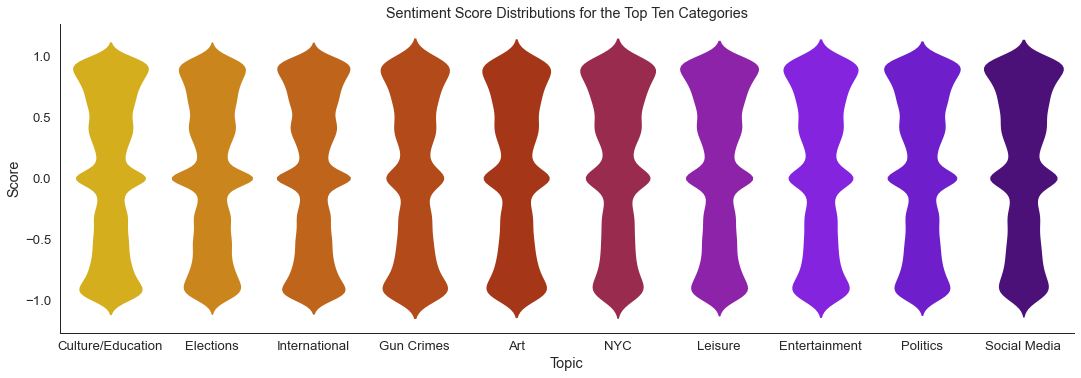

In [23]:
# graphing the top 10 categories

top10 = (comments.groupby('topic')['articleID'].count()
         .reset_index().sort_values('articleID',
                                    ascending=False)
         .head(10).topic)

top10_comments = comments[comments['topic'].isin(top10)]


# create plot

plot = sns.catplot(y="vaderScore", x="topic", 
            kind="violin", data=top10_comments,
            inner='quartile', palette='gnuplot_r',
            split=True, linewidth=0, 
            aspect=3,)

plot.set(title="Sentiment Score Distributions for the Top Ten Categories",
         ylabel="Score", xlabel="Topic")

plot.savefig(file_path + "images/top10.png")

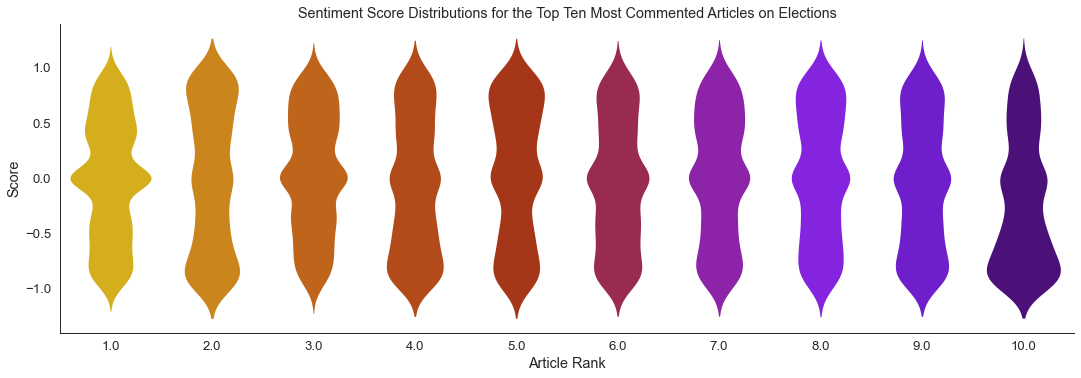

In [24]:
# sample topic top ten articles 

topic1_ranked = (comments[comments['topic'] == 'Elections']
              .groupby('articleID')['topic'].count().reset_index()
              .sort_values('topic', ascending=False))

topic1_ranked['rank'] = topic1_ranked['topic'].rank(ascending=False)
topic1_top10 = topic1_ranked[topic1_ranked['rank'] <= 10 ].articleID

topic1_top10_comments = comments[comments['articleID'].isin(topic1_top10)]

topic1_top10_comments = topic1_top10_comments.merge(topic1_ranked, 
                                                on='articleID', 
                                                how='left')

# create plot

plot = sns.catplot(y="vaderScore", x='rank', 
            kind="violin", data=topic1_top10_comments,
            inner='quartile', palette='gnuplot_r',
            split=True, linewidth=0, 
            aspect=3)

plot.set(title="Sentiment Score Distributions for the Top Ten" +
         " Most Commented Articles on Elections",
         ylabel="Score", xlabel="Article Rank")

plot.savefig(file_path + "images/topic1_top10.png")

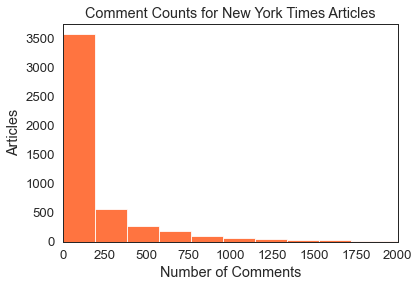

In [18]:
# graphing comment counts

plot = sns.histplot(x='commentCount',
                   data=articles,
                   bins=20,
                   color='orangered')

plot.set(title="Comment Counts for New York Times Articles",
         ylabel="Articles", xlabel="Number of Comments",
         xlim=(0, 2000))

plt.savefig(file_path + "images/commentCounts.png")